# The Deutch-Jozsa algorithm.

Let $f\colon \{0,1\}^n \rightarrow \{0,1\}$ be a Boolean function for some integer $n\geq 1$. We are promised that $f$ is either constant or balanced (takes the values $0$ and $1$ equally many times). The problem is to determine whether $f$ is constant or balanced. The Deutch-Jozsa algorithm solves this problem exponentially faster than any classical deterministic algorithm under the assumption that we have access to a unitary (quantum oracle) $U_f$ that implements
$$ U_f\colon |x\rangle|y\rangle \mapsto |x\rangle|y\oplus f(x)\rangle,$$
where $x\in \{0,1\}^n$ and $y\in \{0,1\}$ and $|x\rangle\in \mathbb{C}^{2^n}$ and $|y\rangle\in \mathbb{C}^2$ are the corresponding computational basis states. Note that $\oplus$ denotes addition modulo $2$.

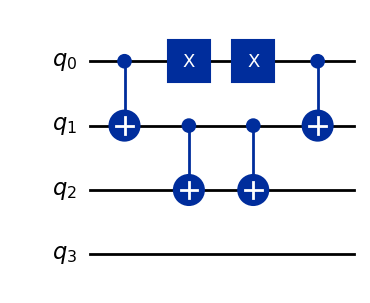

In [ ]:
import numpy as np
from qiskit import QuantumCircuit

# The following function returns the quantum oracle U_(f_i) for three different functions f_0,f_1,f_2
# What the actual functions are will be revealed later.

def Quantum_Oracle(i):
    # Input: i = 0,1,2. Returns: QuantumCircuit for U_(f_i)

    qc = QuantumCircuit(4,name = "U_f")
    qc.cx(0,1)
    qc.cx(1,2)
    qc.x(0)
    if i!=1:
        qc.cx(i,3)
    qc.x(0)
    qc.cx(1,2)
    qc.cx(0,1)
    return qc

# Let us draw the oracle circuit
Quantum_Oracle(1).draw('mpl')       # Pick the input among 0,1,2 to see the circuits for the three functions.

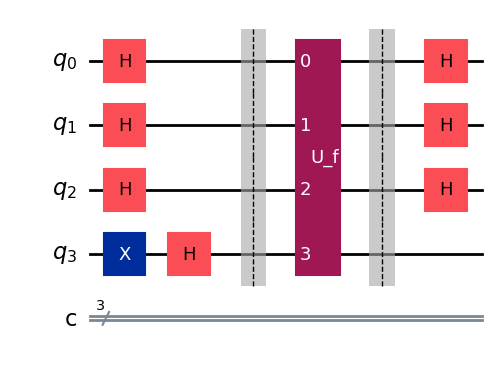

In [ ]:
# We can now set up the Deutch-Josza circuit.

def DJ_circ(i):
    U_f = Quantum_Oracle(i)        # Quantum oracle from the previous cell.
    DJ_qc = QuantumCircuit(4,3)    # Four qubits and three classical bits for the measurement.

    DJ_qc.x(3)                     # Last qubits initiated in |1>
    DJ_qc.h(range(4))              # Applying Hadamard gates on all qubits

    DJ_qc.barrier()                # For visual purposes.
    DJ_qc.append(U_f,range(4))     # Applying the oracle.
    DJ_qc.barrier()

    DJ_qc.h(range(3))              # Applying Hadamard gates on the first three qubits.
    return DJ_qc

# Drawing the full circuit.
qc = DJ_circ(2)
qc.draw('mpl')

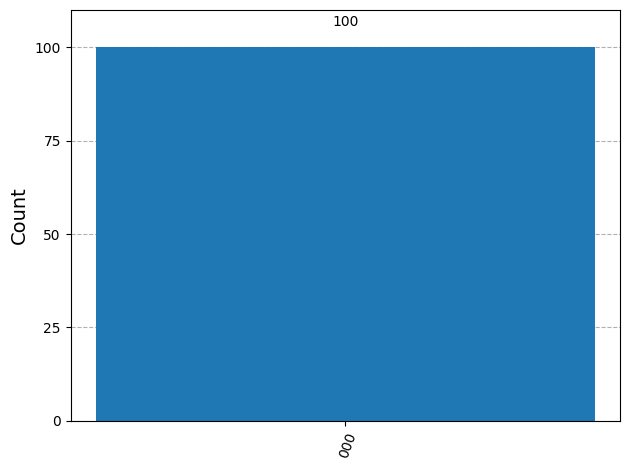

In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# We are ready to simulate the circuit and determine whether f_i is constant or balanced.

i = 1                           # Set i = 0,1,2 to test the different functions f_0,f_1,f_2.
qc = DJ_circ(i)
qc.measure(range(3),range(3))   # Measuring the three first qubits.

# Simulating the circuit 100 times.
simulator = AerSimulator()
comp_qc = transpile(qc,simulator)
job = simulator.run(comp_qc,shots = 100)
counts = job.result().get_counts(qc)
plot_histogram(counts)

Measuring $000$ with probability $1$ means that the function is constant, while measuring $000$ with probability
$0$ means that the function is balanced (theoretically it would therefore suffice to simulate the circuit a single time).

The three functions $f_0,f_1,f_2\colon \{0,1\}^3 \rightarrow \{0,1\}$ are given by
$$ f_0(x_0,x_1,x_2) = x_0\oplus 1, \qquad f_1(x) = 0 \quad \text{ and } \quad f_2(x_1,x_2,x_3) = x_1\oplus x_2\oplus x_3. $$
Therefore, $f_0$ and $f_2$ are balanced, while $f_1$ is constant.

# Grover search.

Let $E\subset \{0,1\}^n$ be a (small) subset for some $n\geq 1$. The search problem is to find an element $y\in E$.
As in the previous problem we assume that we have access to a unitary $U_E$ (quantum oracle) that encodes $E$ in the sense that
$$ O_E\colon |x\rangle |z\rangle \mapsto |x\rangle |z\oplus f(x)\rangle, $$
where $x\in \{0,1\}^n$, $z\in \{0,1\}$ and $f$ is the indicator function of $E$, that is,
$f(x) =1$ if and only if $x\in E$.

Grover's search algorithm works as follows. Initiate in the state $|0\rangle^{\otimes n} (|0\rangle-|1\rangle)/\sqrt2$,
then apply the Grover iteration, given by
$$ G = H^{\otimes n}(2|0\rangle\langle 0|-I)H^{\otimes n} O_E, \qquad K \approx \arccos(\sqrt{r})/\arcsin(2\sqrt{r(1-r)}) \;\; \text{times}, $$
and finally measure the $n$ first qubits.
Here $r = |E|/2^n$ is the ratio of solutions to the total number of elements.


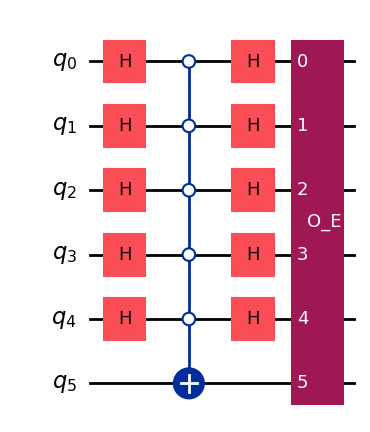

In [ ]:
from qiskit.quantum_info import Statevector

# Setting up the quantum oracle
def O_E():
    # Quantum oracle for {11,13} as a subset of {0,1,2,...,31}.
    qc = QuantumCircuit(6,name = 'O_E')
    qc.cx(1,2)
    qc.mcx([0,2,3,4],5,ctrl_state='0111')
    qc.cx(1,2)
    return qc

# Setting up the Grover iteration operator as given in the above formula
def Grover():
    qc = QuantumCircuit(6)

    # See the formula above
    qc.h(range(5))
    qc.mcx(list(range(5)),5,ctrl_state = '00000')
    qc.h(range(5))
    qc.append(O_E(),range(6))
    return qc

# Drawing the circuit for the grover iteration operator.
Grover().draw('mpl')

The optimal number of iterations is 3


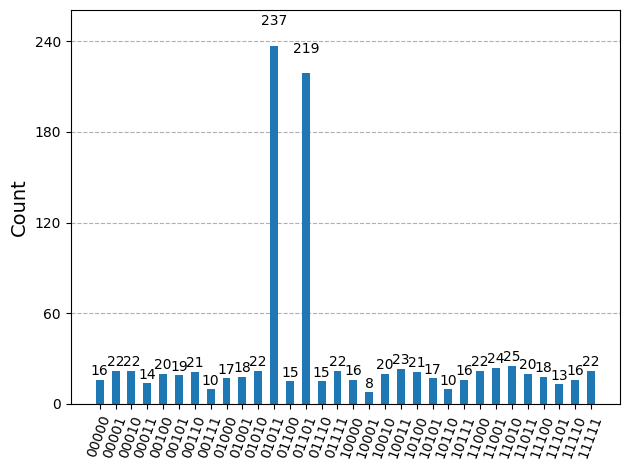

In [ ]:
# We compute the optimal number of iterations and simulate the circuit.

N = 2**5     # Size of search space
M = 2        # Number of solutions
r = M/N      # ratio

a = np.arccos(np.sqrt(r))/np.arcsin(2*np.sqrt(r*(1-r)))
k = int(round(a))                                         # The optimal number of iterations.
print('The optimal number of iterations is',k)

qc = QuantumCircuit(6,5)
qc.x(5)                        # Sets the final qubit in (|0>-|1>)/sqrt(2) and the first 5 in even superposition
qc.h(range(5))


G = Grover()                   # Calling the grover iteration circuit from the previous cell.
for j in range(k):
    qc.append(G,range(6))      # Repeating the Grover iteration k times.

qc.measure(range(5),range(5))

# Simulating the circuit 1000 times.
simulator = AerSimulator()
comp_qc = transpile(qc,simulator)
job = simulator.run(comp_qc,shots = 1000)
counts = job.result().get_counts(qc)
plot_histogram(counts)

The encoded subset was $\{11,13\} \subset \{0,1,2,\cdots,31\}$. So we expect
$11 = [01011]_2$ or $13 = [01101]_2$ to be the most likely outcomes in the simulation.  

# The Quantum Fourier transform and the phase estimation algorithm.

The key component in Shor's famous factorization algorithm is the phase estimation algorithm, which in turn
relies on the quantum Fourier transform (QFT). While Shor's algorithm is too complex to implement here, we will
have a look at both the quantum Fourier transform and the phase estimation algorithm.

The quantum Fourier transform $QFT\colon \mathbb{C}^{2^n}\rightarrow \mathbb{C}^{2^n}$ is given by
$$ |k\rangle \mapsto 2^{-(n/2)} \sum_{j=0}^n e^{2\pi i jk/2^n}|j\rangle   \quad \text{ for } k = 0,1,\cdots,2^{n-1} $$



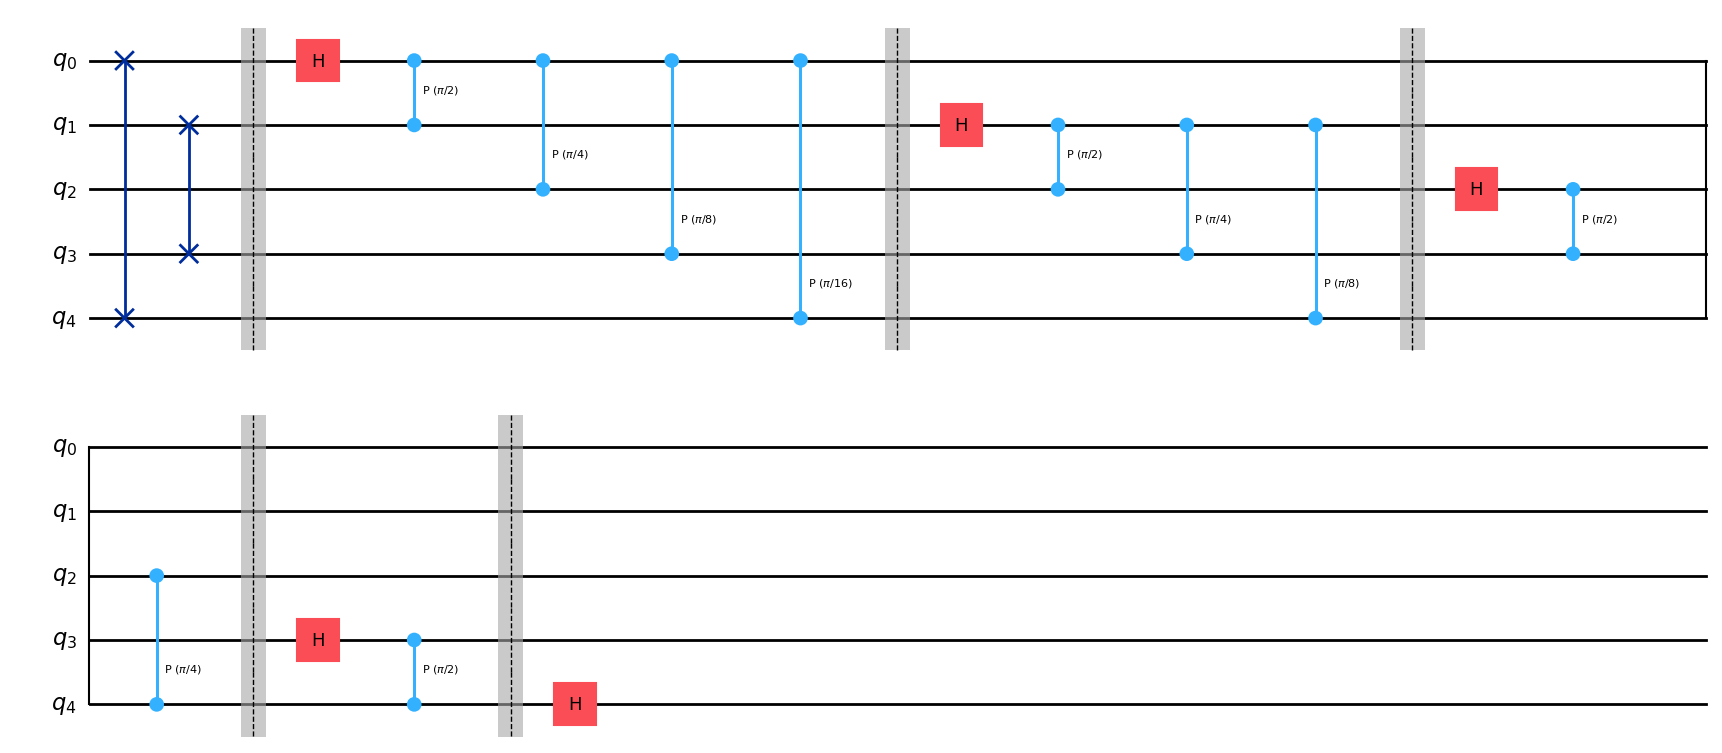

In [ ]:
# Setting up the QFT.
from math import floor

def QFT(n,include_barriers = False):
    # n int: number of qubits
    qc = QuantumCircuit(n,name = "QFT")

    for j in range(floor(n/2)):   # reversing order of the qubits
        qc.swap(j,n-1-j)
    if include_barriers:
        qc.barrier()
    for i in range(n-1):
        qc.h(i)
        k = 2
        for j in range(i+1,n):
            qc.cp(2*np.pi/2**k,i,j)       # Controlled phase gate
            k = k+1
        if include_barriers:
            qc.barrier()
    qc.h(n-1)
    return qc

# The circuit has an apparent recursive structure and uses approximately n(n+2)/2 = O(n^2) 2-qubit gates.
qc = QFT(5,include_barriers = True)          # Vary the number of qubits (2<n<8) to get a sense of the recursive pattern.
qc.draw('mpl')

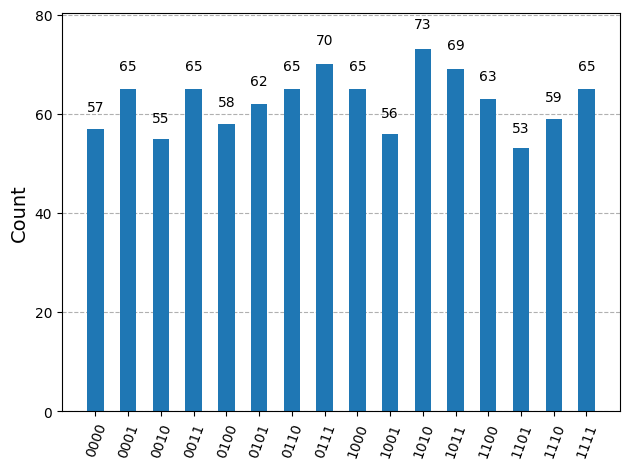

In [ ]:
# Simulating the QFT circuit
init_state = 3        # Vary between 0 and 15 - the output distribution should be the same.

qc = QuantumCircuit(4)
qc.prepare_state(Statevector.from_int(init_state,2**4),range(4))
qc.append(QFT(4),range(4))
qc.measure_all()

# Simulating the circuit 1000 times.
simulator = AerSimulator()
comp_qc = transpile(qc,simulator)
job = simulator.run(comp_qc,shots = 1000)
counts = job.result().get_counts(qc)
plot_histogram(counts)

# The distribution should be uniform for any choice of initial basis state |k>.
# The reason is that all the amplitudes of QFT(|k>) are equal in magnitute.

## Quantum Phase Estimation
Assume that a unitary $U\colon \mathbb{C}^{2^n}\rightarrow \mathbb{C}^{2^n}$ and an eigenvector $|\psi\rangle$ with eigenvalue $e^{i\phi}$ is given, i.e.,
$$ U|\psi\rangle = e^{i\phi}|\psi\rangle .$$
The problem is to estimate $\phi$ to a desired number $m$ of bits.

The phase estimation algorithm operates on two registries. A first work registry with, say, $t$ qubits, and
a second registry on $n$ qubits where the given unitary $U$ acts. One can show that in order to estimate $\phi$
up to $m$ bits of accuracy with a probability of success at least $1-\epsilon$ one has to take
$$ t = m + \lceil \log_2(2+2/\epsilon\rceil .$$

The algorithm initiates the first registry in $2^{-n/2} \sum_{k=0}^{2^t-1} |k\rangle$ and the second in the eigenvector $|\psi\rangle$.
One then applies the operator
$$ \sum_{k=0}^{2^t-1} |k\rangle \langle k|\otimes U^k , $$
followed by an invserse Fourier transform on the first registry. The final step is to measure the first m qubits of the first registry. The most likely outcome encodes the estimate of $\phi$.

In the following example we take the unitary
$$ U = \left( \begin{array}{cc} 1 & 0 \\ 0 & e^{2\pi i \phi} \end{array} \right)  \; \mbox{ with } \; \phi = 0.24 \approx 0.001111010\cdots _2 $$
and eigenvector $|u\rangle = (0,1)^T$.

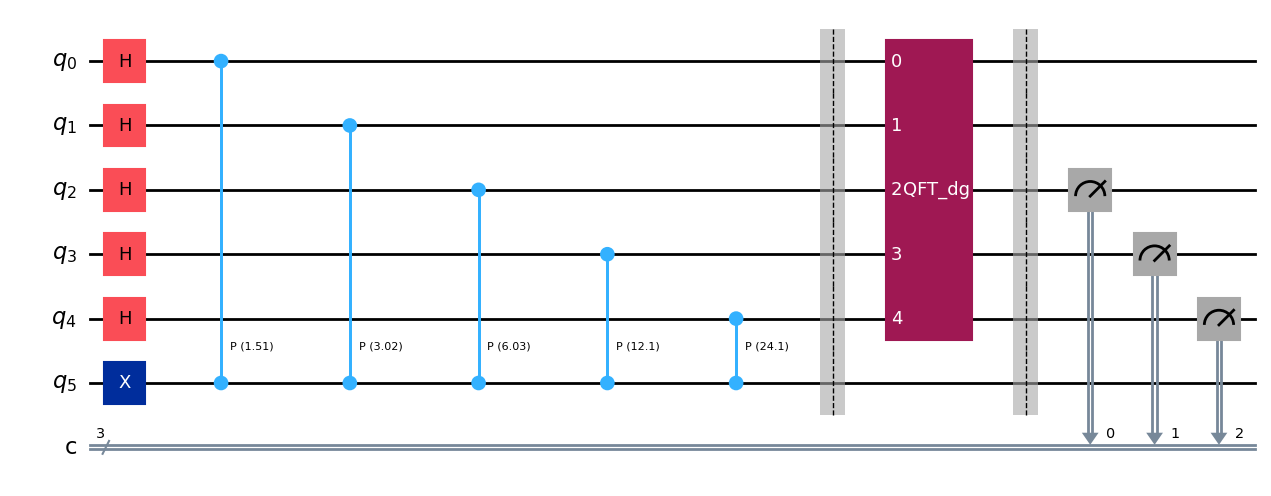

In [ ]:
# A function preparing the quantum phase estimation circuit for U given above.

def QPE_circ(t = 5,m = 3, change_init_state = False):
    # t: number of qubits in the work registry, m: number of bits of precision

    phi = 0.24     # binary 0.001111010...

    qc = QuantumCircuit(t+1,m)            # U acts on a single qubit, so n=1
    qc.x(t)                               # Prepares the final qubit in the eigenstate |1>
    if change_init_state == True:
        qc.h(t)                           # Puts the second registry in a superposition of eigenvectors.

    qc.h(range(t))                        # Prepares the first registry in the even superposition

    for j in range(t):                     # This implements sum_k |k><k|\otimes U^k
        qc.cp(2*np.pi*phi*2**j,j,t)
    qc.barrier()

    # Apply inverse QFT to the work registry
    qc.append(QFT(t).inverse(), range(t))
    qc.barrier()

    # Measuring the m relevant qubits
    qc.measure(range(t-m,t),range(m))
    return qc

QPE_circ().draw('mpl')

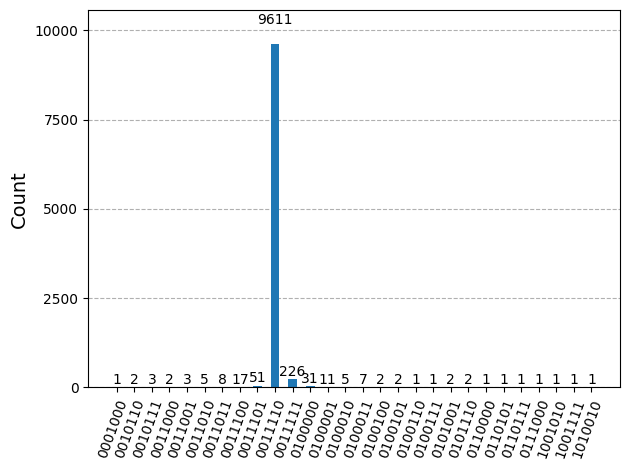

In [ ]:
# Simulting the circuit to obtain an estimate for phi
qc = QPE_circ(t =11,m = 7)

# Simulating the circuit 10000 times.
simulator = AerSimulator()
comp_qc = transpile(qc,simulator)
job = simulator.run(comp_qc,shots = 10000)
counts = job.result().get_counts(qc)

plot_histogram(counts)

Recall that
$$\phi = 0.24 \approx 0.001111010\cdots _2.$$
As $m$ (the number of estimated digits) and $t$ ($=m+a$ where $a>0$ determines the accuracy) are increased, the digits from the decimal point to the right will start to appear with high probability.  

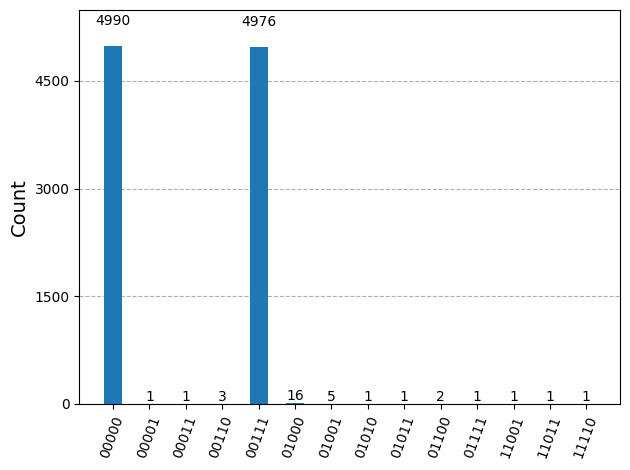

In [ ]:
# What happens if the second registry is not in a pure eigenstate for U?
qc = QuantumCircuit()
qc = QPE_circ(t = 10,m = 5, change_init_state = True)    # Changing the initial state to (|0>-|1>)/sqrt(2)

# Simulating the circuit 10000 times.
simulator = AerSimulator()
comp_qc = transpile(qc,simulator)
job = simulator.run(comp_qc,shots = 10000)
counts = job.result().get_counts(qc)

plot_histogram(counts)

The algorithm still works and outputs a phase estimate for each eigenstate present in the initial state.
Here the other eigenvalue is $1$ with corresponding angle $\phi' = 0$.